In [1]:
import transformers 
import numpy as np
#from transformers import M2M100Tokenizer, M2M100Model
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import wandb

from torch.utils.checkpoint import checkpoint


# Experiment 1: vocabulary overlap
### AZ TO EN

In [2]:
raw_datasets = load_dataset("ted_hrlr", "az_to_en")
metric = load_metric("sacrebleu")

model_checkpoint = "facebook/m2m100_418M"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, src_lang="az", tgt_lang="en")
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# We have to set the model decoding to force the target language as the bos token. 
model.config.forced_bos_token_id = tokenizer.get_lang_id("en")

if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = "translate English to Romanian: "
else:
    prefix = ""

max_input_length = 128
max_target_length = 128
source_lang = "az"
target_lang = "en"

def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)


/home/lcur0594/.conda/envs/M2M/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Found cached dataset ted_hrlr (/home/lcur0594/.cache/huggingface/datasets/ted_hrlr/az_to_en/1.0.0/8714af315cdaad0e48eeea8715047e3571227c959b97b8d5a953fd024cc89509)


  0%|          | 0/3 [00:00<?, ?it/s]

/scratch/ipykernel_32027/428218854.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")
Loading cached processed dataset at /home/lcur0594/.cache/huggingface/datasets/ted_hrlr/az_to_en/1.0.0/8714af315cdaad0e48eeea8715047e3571227c959b97b8d5a953fd024cc89509/cache-c5072d224ac57bf8.arrow
Loading cached processed dataset at /home/lcur0594/.cache/huggingface/datasets/ted_hrlr/az_to_en/1.0.0/8714af315cdaad0e48eeea8715047e3571227c959b97b8d5a953fd024cc89509/cache-e951ee841c1d8f35.arrow
Loading cached processed dataset at /home/lcur0594/.cache/huggingface/datasets/ted_hrlr/az_to_en/1.0.0/8714af315cdaad0e48eeea8715047e3571227c959b97b8d5a953fd024cc89509/cache-228559abe7e3d710.arrow


In [3]:
print("Vocab size: ", tokenizer.vocab_size)
train_az = tokenized_datasets['train']

num = 150
ids_az = train_az['input_ids'][num]
print(train_az['translation'][num])
print(tokenizer.convert_ids_to_tokens(ids_az))

Vocab size:  128112
{'az': 'etdiklərindən zövq alırdılar . bütün vaxtı qumun içində idilər .', 'en': 'they have fun in the moment and they keep playing in the sand .'}
['__az__', '▁etdik', 'lərindən', '▁z', 'öv', 'q', '▁al', 'ırdı', 'lar', '▁.', '▁bütün', '▁vaxt', 'ı', '▁q', 'umun', '▁iç', 'ində', '▁id', 'ilər', '▁.', '</s>']


The first and last entries are special tokens. (Why do we have multiple UNKs?)

In [4]:
n = 30
print(f"First {n} tokens: {tokenizer.convert_ids_to_tokens(np.arange(n))}\n")

print(f"Last {n} tokens: {tokenizer.convert_ids_to_tokens(np.arange(tokenizer.vocab_size-n, tokenizer.vocab_size))}\n")

print()

First 30 tokens: ['<s>', '<pad>', '</s>', '<unk>', ',', '.', '▁de', '-', '▁a', ':', '▁...', '▁(', "'", '▁i', '▁la', '▁-', '▁e', ')', '▁na', '’', '▁en', '▁sa', '▁', '▁на', '?', '▁o', '...', '▁que', '▁in', '▁и']

Last 30 tokens: ['__so__', '__sq__', '__sr__', '__ss__', '__su__', '__sv__', '__sw__', '__ta__', '__th__', '__tl__', '__tn__', '__tr__', '__uk__', '__ur__', '__uz__', '__vi__', '__wo__', '__xh__', '__yi__', '__yo__', '__zh__', '__zu__', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']




\[Training Set\] Entries of the vocabulary as IDs:

In [5]:
train_az = tokenized_datasets['train']
test_az = tokenized_datasets['test']
train_ids_az = np.concatenate(train_az['input_ids']).ravel()
test_ids_az = np.concatenate(test_az['input_ids']).ravel()

# Count frequency of each unique ID
# ----- TRAIN -----
unique_az_train, frequency_az_train = np.unique(train_ids_az, return_counts = True)
vocab_freq_az_train = np.zeros(tokenizer.vocab_size, dtype=np.int32)
vocab_freq_az_train[unique_az_train] = frequency_az_train
# ----- TEST -----
unique_az_test, frequency_az_test = np.unique(test_ids_az, return_counts = True)
vocab_freq_az_test = np.zeros(tokenizer.vocab_size, dtype=np.int32)
vocab_freq_az_test[unique_az_test] = frequency_az_test

### TR TO EN

In [6]:
raw_datasets = load_dataset("ted_hrlr", "tr_to_en")
metric = load_metric("sacrebleu")

model_checkpoint = "facebook/m2m100_418M"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, src_lang="tr", tgt_lang="en")
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# We have to set the model decoding to force the target language as the bos token. 
model.config.forced_bos_token_id = tokenizer.get_lang_id("en")

if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = "translate English to Romanian: "
else:
    prefix = ""

max_input_length = 128
max_target_length = 128
source_lang = "tr"
target_lang = "en"

def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)


/home/lcur0594/.conda/envs/M2M/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Found cached dataset ted_hrlr (/home/lcur0594/.cache/huggingface/datasets/ted_hrlr/tr_to_en/1.0.0/8714af315cdaad0e48eeea8715047e3571227c959b97b8d5a953fd024cc89509)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/lcur0594/.cache/huggingface/datasets/ted_hrlr/tr_to_en/1.0.0/8714af315cdaad0e48eeea8715047e3571227c959b97b8d5a953fd024cc89509/cache-fee50520c3ff8ee0.arrow
Loading cached processed dataset at /home/lcur0594/.cache/huggingface/datasets/ted_hrlr/tr_to_en/1.0.0/8714af315cdaad0e48eeea8715047e3571227c959b97b8d5a953fd024cc89509/cache-f921ca43bad5259e.arrow
Loading cached processed dataset at /home/lcur0594/.cache/huggingface/datasets/ted_hrlr/tr_to_en/1.0.0/8714af315cdaad0e48eeea8715047e3571227c959b97b8d5a953fd024cc89509/cache-e9406205a0daa611.arrow


In [7]:
train_tr = tokenized_datasets['train']
ids_tr = np.concatenate(train_tr['input_ids']).ravel()
# Count frequency of each unique ID
unique_tr, frequency_tr = np.unique(ids_tr, return_counts = True)
vocab_freq_tr = np.zeros(tokenizer.vocab_size, dtype=np.int32)
vocab_freq_tr[unique_tr] = frequency_tr

### PT to EN

In [8]:
raw_datasets = load_dataset("ted_hrlr", "pt_to_en")
metric = load_metric("sacrebleu")

model_checkpoint = "facebook/m2m100_418M"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, src_lang="pt", tgt_lang="en")
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# We have to set the model decoding to force the target language as the bos token. 
model.config.forced_bos_token_id = tokenizer.get_lang_id("en")

if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = "translate English to Romanian: "
else:
    prefix = ""

max_input_length = 128
max_target_length = 128
source_lang = "pt"
target_lang = "en"

def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)


/home/lcur0594/.conda/envs/M2M/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Found cached dataset ted_hrlr (/home/lcur0594/.cache/huggingface/datasets/ted_hrlr/pt_to_en/1.0.0/8714af315cdaad0e48eeea8715047e3571227c959b97b8d5a953fd024cc89509)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/lcur0594/.cache/huggingface/datasets/ted_hrlr/pt_to_en/1.0.0/8714af315cdaad0e48eeea8715047e3571227c959b97b8d5a953fd024cc89509/cache-d157401d9d5262ec.arrow
Loading cached processed dataset at /home/lcur0594/.cache/huggingface/datasets/ted_hrlr/pt_to_en/1.0.0/8714af315cdaad0e48eeea8715047e3571227c959b97b8d5a953fd024cc89509/cache-641f7eacde196c5f.arrow
Loading cached processed dataset at /home/lcur0594/.cache/huggingface/datasets/ted_hrlr/pt_to_en/1.0.0/8714af315cdaad0e48eeea8715047e3571227c959b97b8d5a953fd024cc89509/cache-18f460c7ad7c138f.arrow


In [9]:
train_pt = tokenized_datasets['train']
ids_pt = np.concatenate(train_pt['input_ids']).ravel()
# Count frequency of each unique ID
unique_pt, frequency_pt = np.unique(ids_pt, return_counts = True)
vocab_freq_pt = np.zeros(tokenizer.vocab_size, dtype=np.int32)
vocab_freq_pt[unique_pt] = frequency_pt

## Comparison

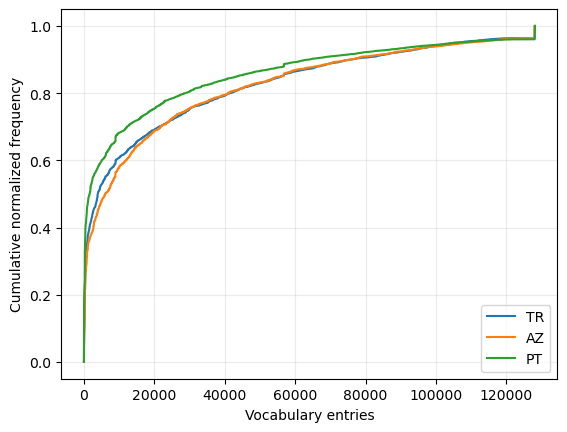

In [18]:
import matplotlib.pyplot as plt

# normalize for comparison
plt.plot(np.arange(tokenizer.vocab_size), np.cumsum(vocab_freq_tr/np.sum(vocab_freq_tr)), label = 'TR')
plt.plot(np.arange(tokenizer.vocab_size), np.cumsum(vocab_freq_az_train/np.sum(vocab_freq_az_train)), label = 'AZ')
plt.plot(np.arange(tokenizer.vocab_size), np.cumsum(vocab_freq_pt/np.sum(vocab_freq_pt)), label = 'PT')
plt.legend(loc='lower right')
plt.xlabel('Vocabulary entries')
plt.ylabel('Cumulative normalized frequency')
plt.grid(alpha=0.25)
plt.savefig('vocab_overlap.pdf')
plt.show()

Plotting but removing entries of the vocab that occur too frequently

In [11]:
az2tr = np.sum(np.minimum(
    vocab_freq_az_train/np.sum(vocab_freq_az_train),
    vocab_freq_tr/np.sum(vocab_freq_tr)))

az2pt = np.sum(np.minimum(
    vocab_freq_az_train/np.sum(vocab_freq_az_train),
    vocab_freq_pt/np.sum(vocab_freq_pt)))

tr2pt = np.sum(np.minimum(
    vocab_freq_tr/np.sum(vocab_freq_tr),
    vocab_freq_pt/np.sum(vocab_freq_pt)))

print(f"The histogram intersection values are:\n• AZ-TR: {az2tr:.3f}\n• AZ-PT: {az2pt:.3f}\n• TR-PT: {tr2pt:.3f}")

The histogram intersection values are:
• AZ-TR: 0.486
• AZ-PT: 0.218
• TR-PT: 0.235


# Experiment 2: Train-test overlap

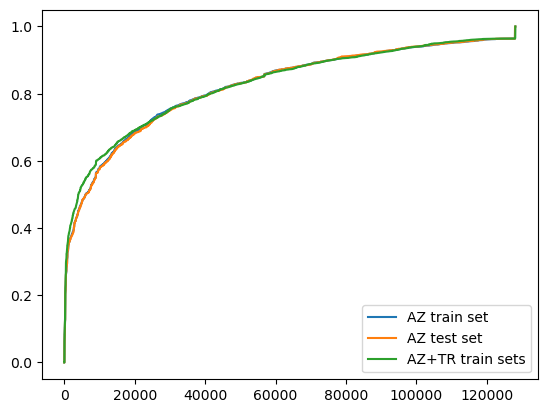

In [12]:
combined_train = vocab_freq_az_train + vocab_freq_tr

plt.plot(np.arange(tokenizer.vocab_size), np.cumsum(vocab_freq_az_train/np.sum(vocab_freq_az_train)), label = 'AZ train set')
plt.plot(np.arange(tokenizer.vocab_size), np.cumsum(vocab_freq_az_test/np.sum(vocab_freq_az_test)), label = 'AZ test set')
plt.plot(np.arange(tokenizer.vocab_size), np.cumsum(combined_train/np.sum(combined_train)), label = 'AZ+TR train sets')
plt.legend(loc='lower right')
plt.show()

In [13]:
test2az_train = np.sum(np.minimum(
    vocab_freq_az_test/np.sum(vocab_freq_az_test),
    vocab_freq_az_train/np.sum(vocab_freq_az_train)))

test2az_tr_train = np.sum(np.minimum(
    vocab_freq_az_test/np.sum(vocab_freq_az_test),
    combined_train/np.sum(combined_train)))


print(f"The histogram intersection values are:\n• AZ test - AZ train   : {test2az_train:.3f}\n• AZ test - AZ+TR train: {test2az_tr_train:.3f}")

The histogram intersection values are:
• AZ test - AZ train   : 0.811
• AZ test - AZ+TR train: 0.447


In [14]:
§

SyntaxError: invalid character '§' (U+00A7) (1036121371.py, line 1)